In [4]:
import pandas as pd
import polars as pl
import numpy as np
import sqlite3
import qrcode

import os

from id_generation.id_generation import generate_ids
from encryption.aes import encrypt_message, decrypt_message, generate_random_encryption_key

```mermaid
erDiagram
    Keys {
        string encrypted_id PK
        string encryption_key
        string uncrypted_id
        datetime date_added
    }
```

In [5]:
conn = sqlite3.connect("database.sqlite")
cur = conn.cursor()

In [6]:
cur.execute("DROP TABLE IF EXISTS keys;")

cur.execute("""
CREATE TABLE keys (
    encrypted_id TEXT PRIMARY KEY,
    encryption_key TEXT NOT NULL,
    unencrypted_id TEXT NOT NULL,
    date_added DATETIME DEFAULT CURRENT_TIMESTAMP
);""")

In [7]:
unencrypted_ids = generate_ids(quantity=2002)
data_insertion = []
for unencrypted_id in unencrypted_ids:
    encryption_key = generate_random_encryption_key()
    encrypted_id = encrypt_message(unencrypted_id, encryption_key)

    data_insertion.append((
        encrypted_id,
        encryption_key,
        unencrypted_id
    ))

data_insertion

[('vq9VsQ2IC0TufI1Iwc+2dUgLEIqt1XUQhtko5VMWiVs=',
  b'\xae1>\xa4\x9eL\xc9B\x91Y\xa8Br\\\x8fMX\x95\xbc\xd0:\x84y\x1e\xe1\x9fUI\x9d\x93\xcda',
  'MP_00001'),
 ('wxiu9lmKrNj0rYPdX67cGxnFn7QRsOFCyXyzvwLUtzI=',
  b'\x13lw\x07&9\xd3qU$\xc7\x0c\x18~\x91\xe3\x1cG\xb3\xb0~\x07\x18\xe9\xc0[G\xf3.r\xcf\x19',
  'MP_00002'),
 ('CE1SL6B2JXMFOU0v9Qt2Tmy69h3y+90oEecOXOx8T8E=',
  b'}\xf7W\xbf\x08=`h\xec\xe9`d\xbe\xef\xcd\xbf\x8bw\xc5\xe0\x97\xa6\x8c\x0b\xa6c\x18\xcerW\xc5\x15',
  'MP_00003'),
 ('T7/fZXRX9r69ZTezpMJvJYxLXdVK0H2Dm98RzkPp98A=',
  b'\xcb:fa\r\xcd\xc6\x1a\x83\xf124]]\x16\x01\x07&j\xc3:z\xdd\xd3\xeb\x00\xa9y\x00\x0e\x84\x1a',
  'MP_00004'),
 ('h91dHsBNy5YYyOMPISggAGfy8sPe9rIlYH0cS9CCFIg=',
  b'P\x96Da\x9c\x00\xdf5*\x80\xf0p\x07\x03\xa6\xed\xf7\xd2\xb3\xdax_K\xfeem&6o\xc5\x18X',
  'MP_00005'),
 ('oIBghINW6P8cIRi89+oV87fDerTLOoKdu67Ru9GqoNs=',
  b"<j'\xba\xaen?3\xdc\xb1W\xf1\x1f\xf9$\xf7eU\xa3THy\xbd\x82\xb4\xedA\xcb\xe9\x1aC\xfd",
  'MP_00006'),
 ('2NgNGuW7vN11Fq5eieGQWLt4t50beHAVtc1/BS9I1Qg=

In [8]:
cur.executemany(
    """INSERT INTO keys (encrypted_id, encryption_key, unencrypted_id) VALUES (?, ?, ?)
    """, data_insertion)
conn.commit()

In [9]:
def fetch_data(query="SELECT * FROM keys", count=1):
    pd.read_sql(query)

In [7]:
key_pairs = cur.execute("SELECT * FROM keys WHERE unencrypted_id = 'MP_00001'").fetchone()
key_pairs

('WqTQp1+UNBSofucBHaml0v+Lyu4Ky4841Qh0guiNJzY=',
 b'y\xae\x8c9F\xb7\x97\x14\xcb\xc48&\x0b\xcf\xab\xd7\x0eB\xf4\x0cBM\x85\x1b\xf3\xcfO->u\xe9g',
 'MP_00001',
 '2024-12-31 11:45:49')

In [10]:
def get_table(table: str, conn = conn):
    """
    This function returns a polars DataFrame from the specified table in the database.
    """
    return pl.read_database(f'SELECT * FROM {table}', conn)

In [11]:
get_table('keys')

encrypted_id,encryption_key,unencrypted_id,date_added
str,binary,str,str
"""vq9VsQ2IC0TufI1Iwc+2dUgLEIqt1X…","b""\xae1>\xa4\x9eL\xc9B\x91Y\xa8Br\\x8fMX\x95\xbc\xd0:\x84y\x1e\xe1\x9fUI\x9d\x93\xcda""","""MP_00001""","""2025-01-04 09:16:44"""
"""wxiu9lmKrNj0rYPdX67cGxnFn7QRsO…","b""\x13lw\x07&9\xd3qU$\xc7\x0c\x18~\x91\xe3\x1cG\xb3\xb0~\x07\x18\xe9\xc0[G\xf3.r\xcf\x19""","""MP_00002""","""2025-01-04 09:16:44"""
"""CE1SL6B2JXMFOU0v9Qt2Tmy69h3y+9…","b""}\xf7W\xbf\x08=`h\xec\xe9`d\xbe\xef\xcd\xbf\x8bw\xc5\xe0\x97\xa6\x8c\x0b\xa6c\x18\xcerW\xc5\x15""","""MP_00003""","""2025-01-04 09:16:44"""
"""T7/fZXRX9r69ZTezpMJvJYxLXdVK0H…","b""\xcb:fa\x0d\xcd\xc6\x1a\x83\xf124]]\x16\x01\x07&j\xc3:z\xdd\xd3\xeb\x00\xa9y\x00\x0e\x84\x1a""","""MP_00004""","""2025-01-04 09:16:44"""
"""h91dHsBNy5YYyOMPISggAGfy8sPe9r…","b""P\x96Da\x9c\x00\xdf5*\x80\xf0p\x07\x03\xa6\xed\xf7\xd2\xb3\xdax_K\xfeem&6o\xc5\x18X""","""MP_00005""","""2025-01-04 09:16:44"""
…,…,…,…
"""yeWVDa+f9/PIuHcuJ8FM1Ae6zOS4Pd…","b""\xa3\xae-cf\xc0\x97\xe3\x19\xc7\x805\xd5R\xf9\xe9\x0e'4I\xf2""0\x83\x81\x8b\xf7\xb3\x0dV\x04H""","""MP_01998""","""2025-01-04 09:16:44"""
"""+6Ey+qSTSumGCfqc35kx2vMjzk/iAZ…","b""\x0a\xbbF\xbd1\x86o\x81\xfa\xe1\xfd\xfa\xfe\xaf\xa0\xdf\x06\xb1\xe1\xd3\xa4\xdb8\xa9\x8d*\xe2p&\xb2\x9f{""","""MP_01999""","""2025-01-04 09:16:44"""
"""XOEBFP+dtBQ1ND77EhYXiD4LVPIG/S…","b""\xcc\x13lK\xcc\x89\x95\x04\xd8nY\xee\xc5\x14\xe2JG\xb4\xcb)hn\x04f~\x8dM\x9ay\xdc\xeb?""","""MP_02000""","""2025-01-04 09:16:44"""


In [10]:
data = get_table('keys').to_pandas()
enc_key = data.loc[0, 'encryption_key']
enc_id = data.loc[1, 'encrypted_id']

In [11]:
enc_id

'8vwxf58YJGRdUkbSRzndvrDE6xDYduvCDeTg6UjK44w='

In [13]:
enc_key

b'y\xae\x8c9F\xb7\x97\x14\xcb\xc48&\x0b\xcf\xab\xd7\x0eB\xf4\x0cBM\x85\x1b\xf3\xcfO->u\xe9g'

In [12]:
decrypt_message(
    encrypted_message = enc_id,
    key = enc_key
)

'ValueError: Invalid padding bytes. Possible wrong key used.'

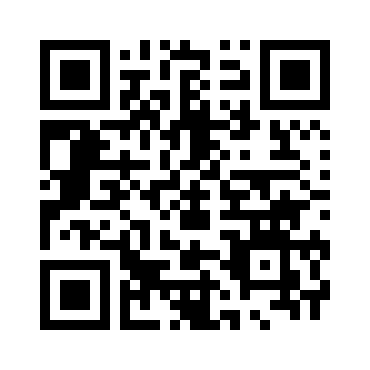

Encrypted data: 8vwxf58YJGRdUkbSRzndvrDE6xDYduvCDeTg6UjK44w=


In [17]:
# Generate the QR code
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(enc_id)
qr.make(fit=True)

# Create and save the QR code image
img = qr.make_image(fill='black', back_color='white')
img.save("encrypted_qr_code.png")

# Optionally, show the image
img.show()

# The encrypted data (this is what is encoded in the QR code)
print("Encrypted data:", enc_id)

In [29]:
# Encrypt the message
key = os.urandom(32)  # 256-bit AES key
encrypted_data = encrypt_message("123", key)


In [32]:
encrypted_data

'Jq0lZZvDAbYQTteXQ3TlN5LvH+T8jQtusp3CI1f2vQA='

In [35]:
decrypt_message(encrypted_data, key)

'123'